In [1]:
import pandas as pd
all_data = pd.read_csv('hmda_2017_ca_all-records_labels.csv')

/home/mattrimol/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (34,36,38,42,44,46,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

# modeling imports
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn import preprocessing, pipeline, decomposition, compose
from sklearn_pandas import DataFrameMapper

import imblearn.under_sampling
import imblearn.over_sampling
import xgboost as xgb

from collections import defaultdict

In [3]:
#Store this to use later on if we want to dig more into interperetablity of results
denials = all_data[['respondent_id', 'denial_reason_name_1', 'denial_reason_name_2', 'denial_reason_name_3']]

all_data.drop([
                'agency_name',
                'agency_code',
                'loan_type',
                'property_type',
                'loan_purpose',
                'owner_occupancy',
                'preapproval',
                'action_taken',
                'msamd',
                'state_name',
                'state_code',
                'county_code',
                'applicant_ethnicity',
                'co_applicant_ethnicity',
                'applicant_race_1',
                'applicant_race_2',
                'applicant_race_3',
                'applicant_race_4',
                'applicant_race_5',
                'co_applicant_race_1',
                'co_applicant_race_2',
                'co_applicant_race_3',
                'co_applicant_race_4',
                'co_applicant_race_5',
                'applicant_sex',
                'co_applicant_sex',
                'purchaser_type',
                'denial_reason_1',
                'denial_reason_2',
                'denial_reason_3',
                'denial_reason_name_1', #Stored in denials table
                'denial_reason_name_2', #Stored in denials table
                'denial_reason_name_3', #Stored in denials table
                'hoepa_status',
                'lien_status',
                'edit_status',
                'edit_status_name',
                'sequence_number',
                'application_date_indicator',
                'rate_spread'],axis=1, inplace=True)

#Only do this if single state and single year
all_data.drop(['as_of_year', 'state_abbr'], axis=1, inplace=True)

#Shortening some strings
all_data.replace('One-to-four family dwelling (other than manufactured housing)',
                 '1 to 4 family (excl. manufactured)', inplace=True)
all_data.replace('Information not provided by applicant in mail, Internet, or telephone application',
                 'Info not provided', inplace=True)

## Subjective Cleaning

In [4]:
# Likely too much complexity to go beyond two race listings
all_data.drop(['applicant_race_name_3',
               'applicant_race_name_4',
               'applicant_race_name_5',
               'co_applicant_race_name_3',
               'co_applicant_race_name_4',
               'co_applicant_race_name_5'], axis=1, inplace=True)

In [5]:
# Filter down to applications accepted or denied (remove preapprovals and incompletes) and make binary
acc_or_den_filter = (all_data['action_taken_name'] == 'Loan originated') |\
                    (all_data['action_taken_name'] == 'Application denied by financial institution')
all_data = all_data[acc_or_den_filter]

all_data['action_taken_name'].replace('Loan originated', 0, inplace=True)
all_data['action_taken_name'].replace('Application denied by financial institution', 1, inplace=True)

In [6]:
#Droping all the entires where we don't have census data
all_data = all_data[all_data['population'].notna()]

In [7]:
#Droping where loan_amount_000s is na
all_data = all_data[all_data['loan_amount_000s'].notna()]

In [8]:
all_data.drop(['county_name', #Too many
               'census_tract_number', #Too many
               'purchaser_type_name',
               'hoepa_status_name', #Most are not HOEPA
               'lien_status_name', #Probably exclude since vast majority are in one category
              ], axis=1, inplace=True)

In [9]:
# Unreported incomes seem to have similar loan amounts as reported incomes
# Droping nulls for now, but consider filling with median. Probably big enough sample to just drop though.
all_data = all_data[all_data['applicant_income_000s'].notna()]

In [10]:
# Null location for Metropolitan Statistical Area/Metropolitan Division calling 'Other'
all_data.loc[all_data['msamd_name'] == np.nan, 'msamd_name'] = 'Other'

In [11]:
#all_data.info()

## Outlier Handling

In [12]:
#Dropping multifamily dwellings
multifamily = all_data['property_type_name'] == 'Multifamily dwelling'
all_data = all_data.drop(all_data[multifamily].index)

In [13]:
# We want to exclude huge purchases and really small ones
# Magic numbers here consider review
loan_amt_filter = (all_data['loan_amount_000s'] > 25) &\
                  (all_data['loan_amount_000s'] < 20000)
all_data = all_data[loan_amt_filter]

## Feature Engineering

In [14]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1015606 entries, 0 to 1710448
Data columns (total 25 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   respondent_id                   1015606 non-null  object 
 1   agency_abbr                     1015606 non-null  object 
 2   loan_type_name                  1015606 non-null  object 
 3   property_type_name              1015606 non-null  object 
 4   loan_purpose_name               1015606 non-null  object 
 5   owner_occupancy_name            1015606 non-null  object 
 6   loan_amount_000s                1015606 non-null  float64
 7   preapproval_name                1015606 non-null  object 
 8   action_taken_name               1015606 non-null  int64  
 9   msamd_name                      991323 non-null   object 
 10  applicant_ethnicity_name        1015606 non-null  object 
 11  co_applicant_ethnicity_name     1015606 non-null  object 
 12  

In [15]:
# binary column, has coapplicant?
def has_coapp(row):
    if row['co_applicant_sex_name'] == 'No co-applicant':
        return 0
    else:
        return 1
all_data['has_coapplicant'] = all_data.apply(lambda row: has_coapp(row), axis=1)

In [16]:
# 1 if backed by ANY federal agency
def fed_insured(row):
    if row['loan_type_name'] == 'Conventional':
        return 0
    else:
        return 1
all_data['fed_insured'] = all_data.apply(lambda row: fed_insured(row), axis=1)
all_data.drop('loan_type_name', axis=1, inplace=True)

In [17]:
# Loan amount / Income
all_data['loan_amount/applicant_income'] = all_data['loan_amount_000s']/all_data['applicant_income_000s']

## Helper Functions

In [18]:
def get_cols(df):
    '''Print vertical list so you can paste into excel and make notes'''
    for col in df.columns:
        print(col)

In [19]:
def check_feature(df, feature):
    if is_numeric_dtype(df[feature]):
        plt.hist(df[feature])
    else:
        print(df[feature].value_counts())
        ((df[feature].value_counts() / len(df[feature]))*100).sort_values().plot(kind = 'barh')
        plt.xticks(np.arange(0, 100, 5))

In [20]:
def create_model_df(df, features_list):
    return df[features_list + ['action_taken_name']].dropna()

## EDA

In [21]:
for count in all_data['action_taken_name'].value_counts():
    print(count/len(all_data['action_taken_name']))

0.7985842935153987
0.2014157064846013


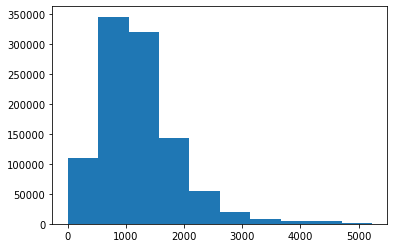

In [22]:
check_feature(all_data, 'number_of_owner_occupied_units')

In [23]:
get_cols(all_data)

respondent_id
agency_abbr
property_type_name
loan_purpose_name
owner_occupancy_name
loan_amount_000s
preapproval_name
action_taken_name
msamd_name
applicant_ethnicity_name
co_applicant_ethnicity_name
applicant_race_name_1
applicant_race_name_2
co_applicant_race_name_1
co_applicant_race_name_2
applicant_sex_name
co_applicant_sex_name
applicant_income_000s
population
minority_population
hud_median_family_income
tract_to_msamd_income
number_of_owner_occupied_units
number_of_1_to_4_family_units
has_coapplicant
fed_insured
loan_amount/applicant_income


## Creating Models

#### Choose features and make a dataframe with those

In [24]:
# Simple bare bones model
features_1 = ['applicant_income_000s', 'fed_insured']
model1 = create_model_df(all_data, features_1)

In [25]:
# Throw a lot at it
features_2 = ['loan_purpose_name', 'owner_occupancy_name', 'loan_amount_000s',
              'applicant_race_name_1', 'applicant_income_000s', 'population',
              'minority_population', 'hud_median_family_income', 'tract_to_msamd_income',
              'has_coapplicant', 'fed_insured']
model2 = create_model_df(all_data, features_2)

In [26]:
features_3 = ['loan_purpose_name', 'owner_occupancy_name', 'loan_amount/applicant_income', 'tract_to_msamd_income']
model3 = create_model_df(all_data, features_3)

#### Split Train/Test

In [27]:
def make_splits(df):
    '''Makes X_train, X_test, y_train_y_test given a data frame with features and action_taken_name as y.
    Use this to make sure we don't mess up getting data from the wrong df'''
    return train_test_split(df[np.setdiff1d(df.columns, ['action_taken_name'])],
                                          df['action_taken_name'],
                                          test_size = 0.2, random_state=42)

In [28]:
X_tr1, X_te1, y_tr1, y_te1 = make_splits(model1)

In [29]:
X_tr2, X_te2, y_tr2, y_te2 = make_splits(model2)

In [30]:
X_tr3, X_te3, y_tr3, y_te3 = make_splits(model3)

##### Preprocessing

In [31]:
def preprocess_columns(X_train, X_test):
    num_cols = []
    cat_cols = []
    
    #This is a list that will be the dummy column to drop (it will be the one with the lowest value count)
    drop_dummy_cols = []
    
    # Create the column lists from X_train and then apply the procedure to X_train and X_test
    for feature in X_train.columns:
        if type(all_data[feature].iloc[0]) == str:
            cat_cols.append(feature) # Creating the list of columns that are categorical

            # Gets the category name with the lowest count (this will be the dummy column we drop)
            min_cat = all_data[feature].value_counts().keys()[-1]

            drop_dummy_cols.append(feature + '_' + min_cat) #string convention from pd.get_dummies

        else:
            num_cols.append(feature) #Columns that will get the standard scaler
    
    
    std_scale = preprocessing.StandardScaler()
    for column in X_train.columns:
        if column in num_cols:
            #standard scaling the numerical columns
            X_train[column] = std_scale.fit_transform(np.array(X_train[column]).reshape(-1, 1))
            X_test[column] = std_scale.fit_transform(np.array(X_test[column]).reshape(-1, 1))
    
    #Get dummies for the categoricals and drop the one with the lowest value count
    X_train = pd.get_dummies(X_train)
    X_test = pd.get_dummies(X_test)
    X_train.drop(drop_dummy_cols, axis=1, inplace=True)
    X_test.drop(drop_dummy_cols, axis=1, inplace=True)
    
    return X_train, X_test

#### Pairplot

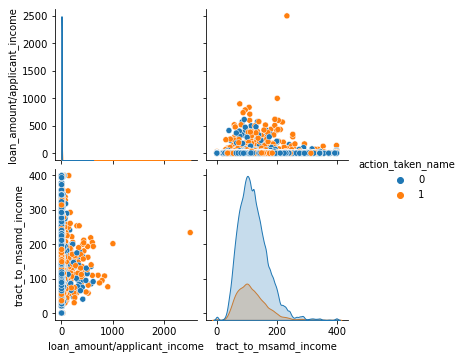

In [32]:
sns.pairplot(model3.sample(frac=0.3, replace=True, random_state=1), hue='action_taken_name');

In [33]:
#sorted(metrics.SCORERS.keys())

In [34]:
# 20% is denials (action_taken_name = 1)
# 80% is loan originated
def under_sample_bal(X_train, y_train):
    '''pass in training data and return X_train_rs, y_train_rs'''
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    ratio = {1 : int(n_pos), 0 : int(n_neg/4)} 

    ROS = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = ratio, random_state=42) 
    return ROS.fit_resample(X_train, y_train)

In [35]:
def cross_validate(X_train, y_train, model, display_results=True, eval_metric=None):
    '''
    Cross validates and scores a model. Automattically standardizes numerical features, dummifies categoricals,
    and rebalances data with undersampling function.
    Inputs:
    X_train: Full X_train data
    y_train: Full y_train data
    model: empty model such as RandomForestClassifier(). Specify hyperparameters if necessary.
    display_results: If True, function will print out averae metrics across K Folds
    eval_metric: Input string that corresponds to a metric in scores dict (see below). If specified,
    the function will return a value for that metric's average. Can be used to cross validate to optimize for a metric.
    '''
      
    
    scores = {'accuracy': [], 'recall': [], 'roc_auc': [], 'f1': [], 'precision': []}
    sfk = StratifiedKFold(n_splits=5)
    
    for train_index, test_index in sfk.split(X_train, y_train):
        #create a train/val set for a split
        X_tr, X_val = X_train.iloc[train_index].copy(), X_train.iloc[test_index].copy()
        y_tr, y_val = y_train.iloc[train_index].copy(), y_train.iloc[test_index].copy()
        
        #preprocess X sets
        X_tr_proc, X_val_proc = preprocess_columns(X_tr, X_val)

        #Balance pos/neg class with undersampling
        X_tr_rs, y_tr_rs = under_sample_bal(X_tr_proc, y_tr)
        #print(np.sum(y_tr_rs == 1), np.sum(y_tr_rs == 0)) ###Checker to make sure balanced right
        
        #fit to train
        model.fit(X_tr_rs, y_tr_rs)
        #score on val
        y_pred = model.predict(X_val_proc)
        
        # Score test data
        accuracy = metrics.accuracy_score(y_val, y_pred)
        scores['accuracy'].append(accuracy)
        
        recall = metrics.recall_score(y_val, y_pred)
        scores['recall'].append(recall)
        
        roc_auc = metrics.roc_auc_score(y_val, y_pred)
        scores['roc_auc'].append(roc_auc)       
        
        f1 = metrics.f1_score(y_val, y_pred)
        scores['f1'].append(f1)
        
        precision = metrics.precision_score(y_val, y_pred)
        scores['precision'].append(precision)
    
    if display_results:
        print('Means:')
        for metric in scores:
            mean = np.mean(scores[metric])
            all_scores = np.array(scores[metric])
            print('{:<20s}{:>15.2f}     {}'.format(metric, mean, all_scores))
            
    if eval_metric:
        return np.mean(scores[eval_metric])

In [36]:
# Logistic model hyperparameters
solver = 'liblinear'
max_iter = 200

def log_cross_val(X_train, y_train):
    '''Cross validates a logistic model on many C values and returns optimal C'''
    C_results = defaultdict()

    for C in [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100, 1000, 10000]:
        logreg = LogisticRegression(C=C, solver=solver, max_iter=max_iter)
        eval_result = cross_validate(X_train, y_train, logreg, display_results=False, eval_metric='roc_auc')
        C_results[eval_result] = C

    best_score = max(C_results.keys())
    optimal_C = C_results[best_score]


    logreg = LogisticRegression(C=optimal_C, solver=solver, max_iter=max_iter)
    cross_validate(X_train, y_train, logreg)
    
    print(f'Optimal C: {optimal_C}')

##### Logistic Models

In [37]:
log_cross_val(X_tr1, y_tr1)

Means:
accuracy                       0.44     [0.44196508 0.43715884 0.43890041 0.44146046 0.43977698]
recall                         0.73     [0.73563113 0.73590613 0.73554754 0.72671718 0.7409784 ]
roc_auc                        0.55     [0.55176794 0.5488616  0.54981648 0.54811766 0.55239705]
f1                             0.35     [0.34682955 0.34497379 0.34557108 0.34387583 0.34758553]
precision                      0.23     [0.2269043  0.22529256 0.22583611 0.22522514 0.22704504]
Optimal C: 0.001


In [38]:
log_cross_val(X_tr2, y_tr2)

Means:
accuracy                       0.57     [0.56602276 0.56789356 0.56732124 0.56941974 0.56887554]
recall                         0.70     [0.70645033 0.70480032 0.70419824 0.70276216 0.69868916]
roc_auc                        0.62     [0.61852917 0.61908352 0.61849942 0.61927634 0.61741322]
f1                             0.40     [0.39602604 0.39650015 0.39598636 0.39666115 0.39496321]
precision                      0.28     [0.27513001 0.2758398  0.27543472 0.27630947 0.27529165]
Optimal C: 1.0


In [39]:
log_cross_val(X_tr3, y_tr3)

Means:
accuracy                       0.53     [0.53850225 0.53364678 0.53149904 0.53792993 0.52672681]
recall                         0.74     [0.73367556 0.74580622 0.74682229 0.73774749 0.75032847]
roc_auc                        0.61     [0.6114783  0.612974   0.61200819 0.61264152 0.61033211]
f1                             0.39     [0.39037833 0.39179113 0.3910282  0.39140831 0.3897252 ]
precision                      0.27     [0.26594083 0.26567976 0.26485057 0.26636292 0.26322221]
Optimal C: 1.0


##### Random Forest Classifier Models

In [40]:
rfc = RandomForestClassifier()

In [41]:
cross_validate(X_tr1, y_tr1, rfc)

Means:
accuracy                       0.63     [0.63371016 0.6186945  0.63756254 0.65380899 0.6216153 ]
recall                         0.46     [0.45974272 0.4782901  0.45373992 0.41246028 0.4740734 ]
roc_auc                        0.57     [0.56866307 0.56619676 0.56883144 0.56356895 0.56644896]
f1                             0.33     [0.33579949 0.33565999 0.33523337 0.32428861 0.33540144]
precision                      0.26     [0.2644939  0.25855633 0.26580987 0.26717467 0.25949589]


In [42]:
cross_validate(X_tr2, y_tr2, rfc)

Means:
accuracy                       0.64     [0.64766119 0.63078703 0.64460882 0.65737829 0.63496948]
recall                         0.64     [0.63235249 0.6544749  0.63315815 0.60804204 0.64805818]
roc_auc                        0.64     [0.64193721 0.63964401 0.64032743 0.63893152 0.63986338]
f1                             0.42     [0.41958964 0.41657428 0.41780753 0.41686305 0.41695009]
precision                      0.31     [0.31395543 0.30551871 0.31176842 0.31714664 0.30734563]


In [43]:
cross_validate(X_tr3, y_tr3, rfc)

Means:
accuracy                       0.59     [0.58330923 0.59258325 0.59744488 0.59219555 0.60373794]
recall                         0.57     [0.59565496 0.57961316 0.56932901 0.58109264 0.54031839]
roc_auc                        0.59     [0.58792535 0.58773368 0.58693238 0.58804418 0.58002519]
f1                             0.36     [0.36540174 0.36429106 0.36293339 0.36466832 0.35452149]
precision                      0.27     [0.26353215 0.26561647 0.26636837 0.2657073  0.26380725]


In [44]:
##### Gradient Boosted Machine

In [47]:
# These hyperparameters are not tuned
gbm = xgb.XGBClassifier( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:squarederror",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

In [48]:
cross_validate(X_tr1, y_tr1, gbm)

/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/mattrimol/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py

KeyboardInterrupt: 

In [ ]:
cross_validate(X_tr2, y_tr2, gbm)

In [ ]:
cross_validate(X_tr3, y_tr3, gbm)

#### Testing on Best Model

In [51]:
def test(X_train, X_test, y_train, y_test, model):    
    #preprocess X sets
    X_train_proc, X_test_proc = preprocess_columns(X_train, X_test)
    #Balance pos/neg class with undersampling
    X_train_rs, y_train_rs = under_sample_bal(X_train_proc, y_train)
    #fit to train
    model.fit(X_train_rs, y_train_rs)
    #generate predictions
    y_pred = model.predict(X_test_proc)
    
    # Now that everything is transformed use:
        # X_train_rs
        # X_test_proc
        # y_train_rs
        # y_test       

    # Score test data
    accuracy = metrics.accuracy_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)

    print('Important:')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')

    print(metrics.confusion_matrix(y_test, y_pred))

    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test_proc)[:,1])
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve');
    print("ROC AUC score = ", metrics.roc_auc_score(y_test, model.predict_proba(X_test_proc)[:,1]))
    
    #for feature, coef in X_train_rs.columns, model.coef_:
        #print('{:<20s}{:>15.2f}'.format(feature, coef))
    try:
        print(model.coef_)
    except AttributeError:
        pass

    plt.show()


    print('\nLess Important:')
    print(f'Precision: {precision}')

Important:
Accuracy: 0.6600565177578007
Recall: 0.587923366404379
[[110013  52187]
 [ 16863  24059]]
ROC AUC score =  0.6832607217598594


AttributeError: 'RandomForestClassifier' object has no attribute 'coef_'

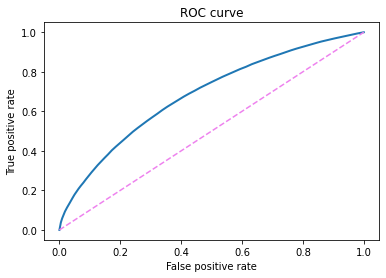

In [52]:
test(X_tr2, X_te2, y_tr2, y_te2, rfc)